<a href="https://colab.research.google.com/github/emuanel/denoising_ecg/blob/main/projektOPSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>


In [ ]:
#@title
%%html 
<iframe src="https://www.polskacyfrowa.gov.pl/media/48246/FE_POPC_poziom_pl-1_rgb.jpg" width="800"></iframe>


# Obliczeniowe podstawy sztucznej inteligencji - Projekt Odszumić sygnał EKG wykorzystując min. 3 metody

Jan Filip 171855, Politechnika Gdańska, Wydział ETI, Inżynieria Biomedyczna, Sztuczna inteligencja grupa 1

Konrad Wyszyński 171935, Politechnika Gdańska, Wydział ETI, Inżynieria Biomedyczna, Sztuczna inteligencja grupa 1

1.   Spline approximation
2.   Autoregressive Model
3.   Wavelet Transform

In [ ]:
!pip install wfdb
!pip install statsmodels --upgrade

     |████████████████████████████████| 143kB 4.0MB/s 
     |████████████████████████████████| 9.5MB 3.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Wczytanie sygnałów EKG pochodzących z repozytorium Physionet - MIT-BIH Arrhythmia Database

https://www.physionet.org/content/mitdb/1.0.0/

In [ ]:
"""## Setup"""
import wfdb
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pywt
import sys
import statistics
from math import log10

"""## Utils"""
def readSignals(records):
    data = []
    for rec in records:
        path = rec[:-4]
        x, y = wfdb.rdsamp(path, channels=[0,1])
        data.append((x[:,0]))
        #data.append((x[:,1]))    #chanel 2
    return data

path1='/content/drive/MyDrive/projekty/ObliczeniowepodstawyAI/mit-bih-arrhythmia-database-1.0.0/'

records=glob.glob(path1+"*.atr")
data=readSignals(records[:]) 
nsignals = len(data)
nsignals

48

In [ ]:
#skrócenie sygnałów do 5000 próbek
nsample = 5000
for i in range(len(data)):
    data[i] = data[i][:5000]

Przykładowy sygnał EKG

Text(0, 0.5, 'Amplituda [mV]')

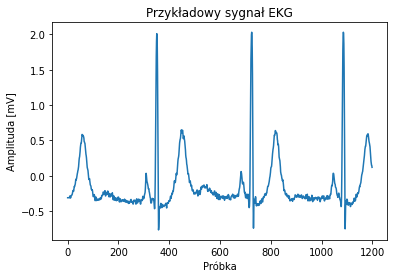

In [ ]:
signal = data[5]
plt.plot(signal[:1200])
plt.title("Przykładowy sygnał EKG")
plt.xlabel("Próbka")
plt.ylabel("Amplituda [mV]")

Zaszumianie sygnałów

In [ ]:
noisyData = data
for i in noisyData:
  noise = np.random.normal(0,1,len(i))*0.07
  i += noise

Przykładowy zaszumiony sygnał EKG

Text(0, 0.5, 'Amplituda [mV]')

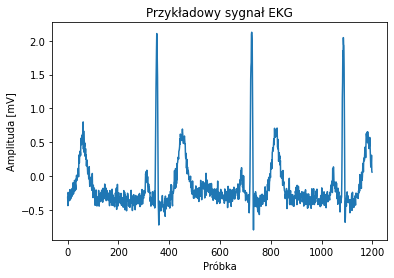

In [ ]:
signal = noisyData[5]
plt.plot(signal[:1200])
plt.title("Przykładowy sygnał EKG")
plt.xlabel("Próbka")
plt.ylabel("Amplituda [mV]")

Algorytm 1 - spline approximation - Jan Filip


In [ ]:
import scipy.interpolate as si 
splines = []
denoised_signal_spline = []
for i in noisyData:
    y = i
    x = np.arange(y.size)
    k = 3 
    spline = si.UnivariateSpline(x, y, k=k , s=20)
    splines.append([spline, spline.get_knots()])

    denoised_signal_spline.append(spline(x))
    #xmin, xmax = min(x), max(x) 
    #ymin, ymax = min(y), max(y)
    # nknot = 100
    # knot_offset = (xmax - xmin)/(nknot + 1)
    # knots = np.linspace(knot_offset, xmax-knot_offset, nknot)
    # lsqspline = si.LSQUnivariateSpline(x, y, knots, k=k)
    
    

<Figure size 432x288 with 0 Axes>

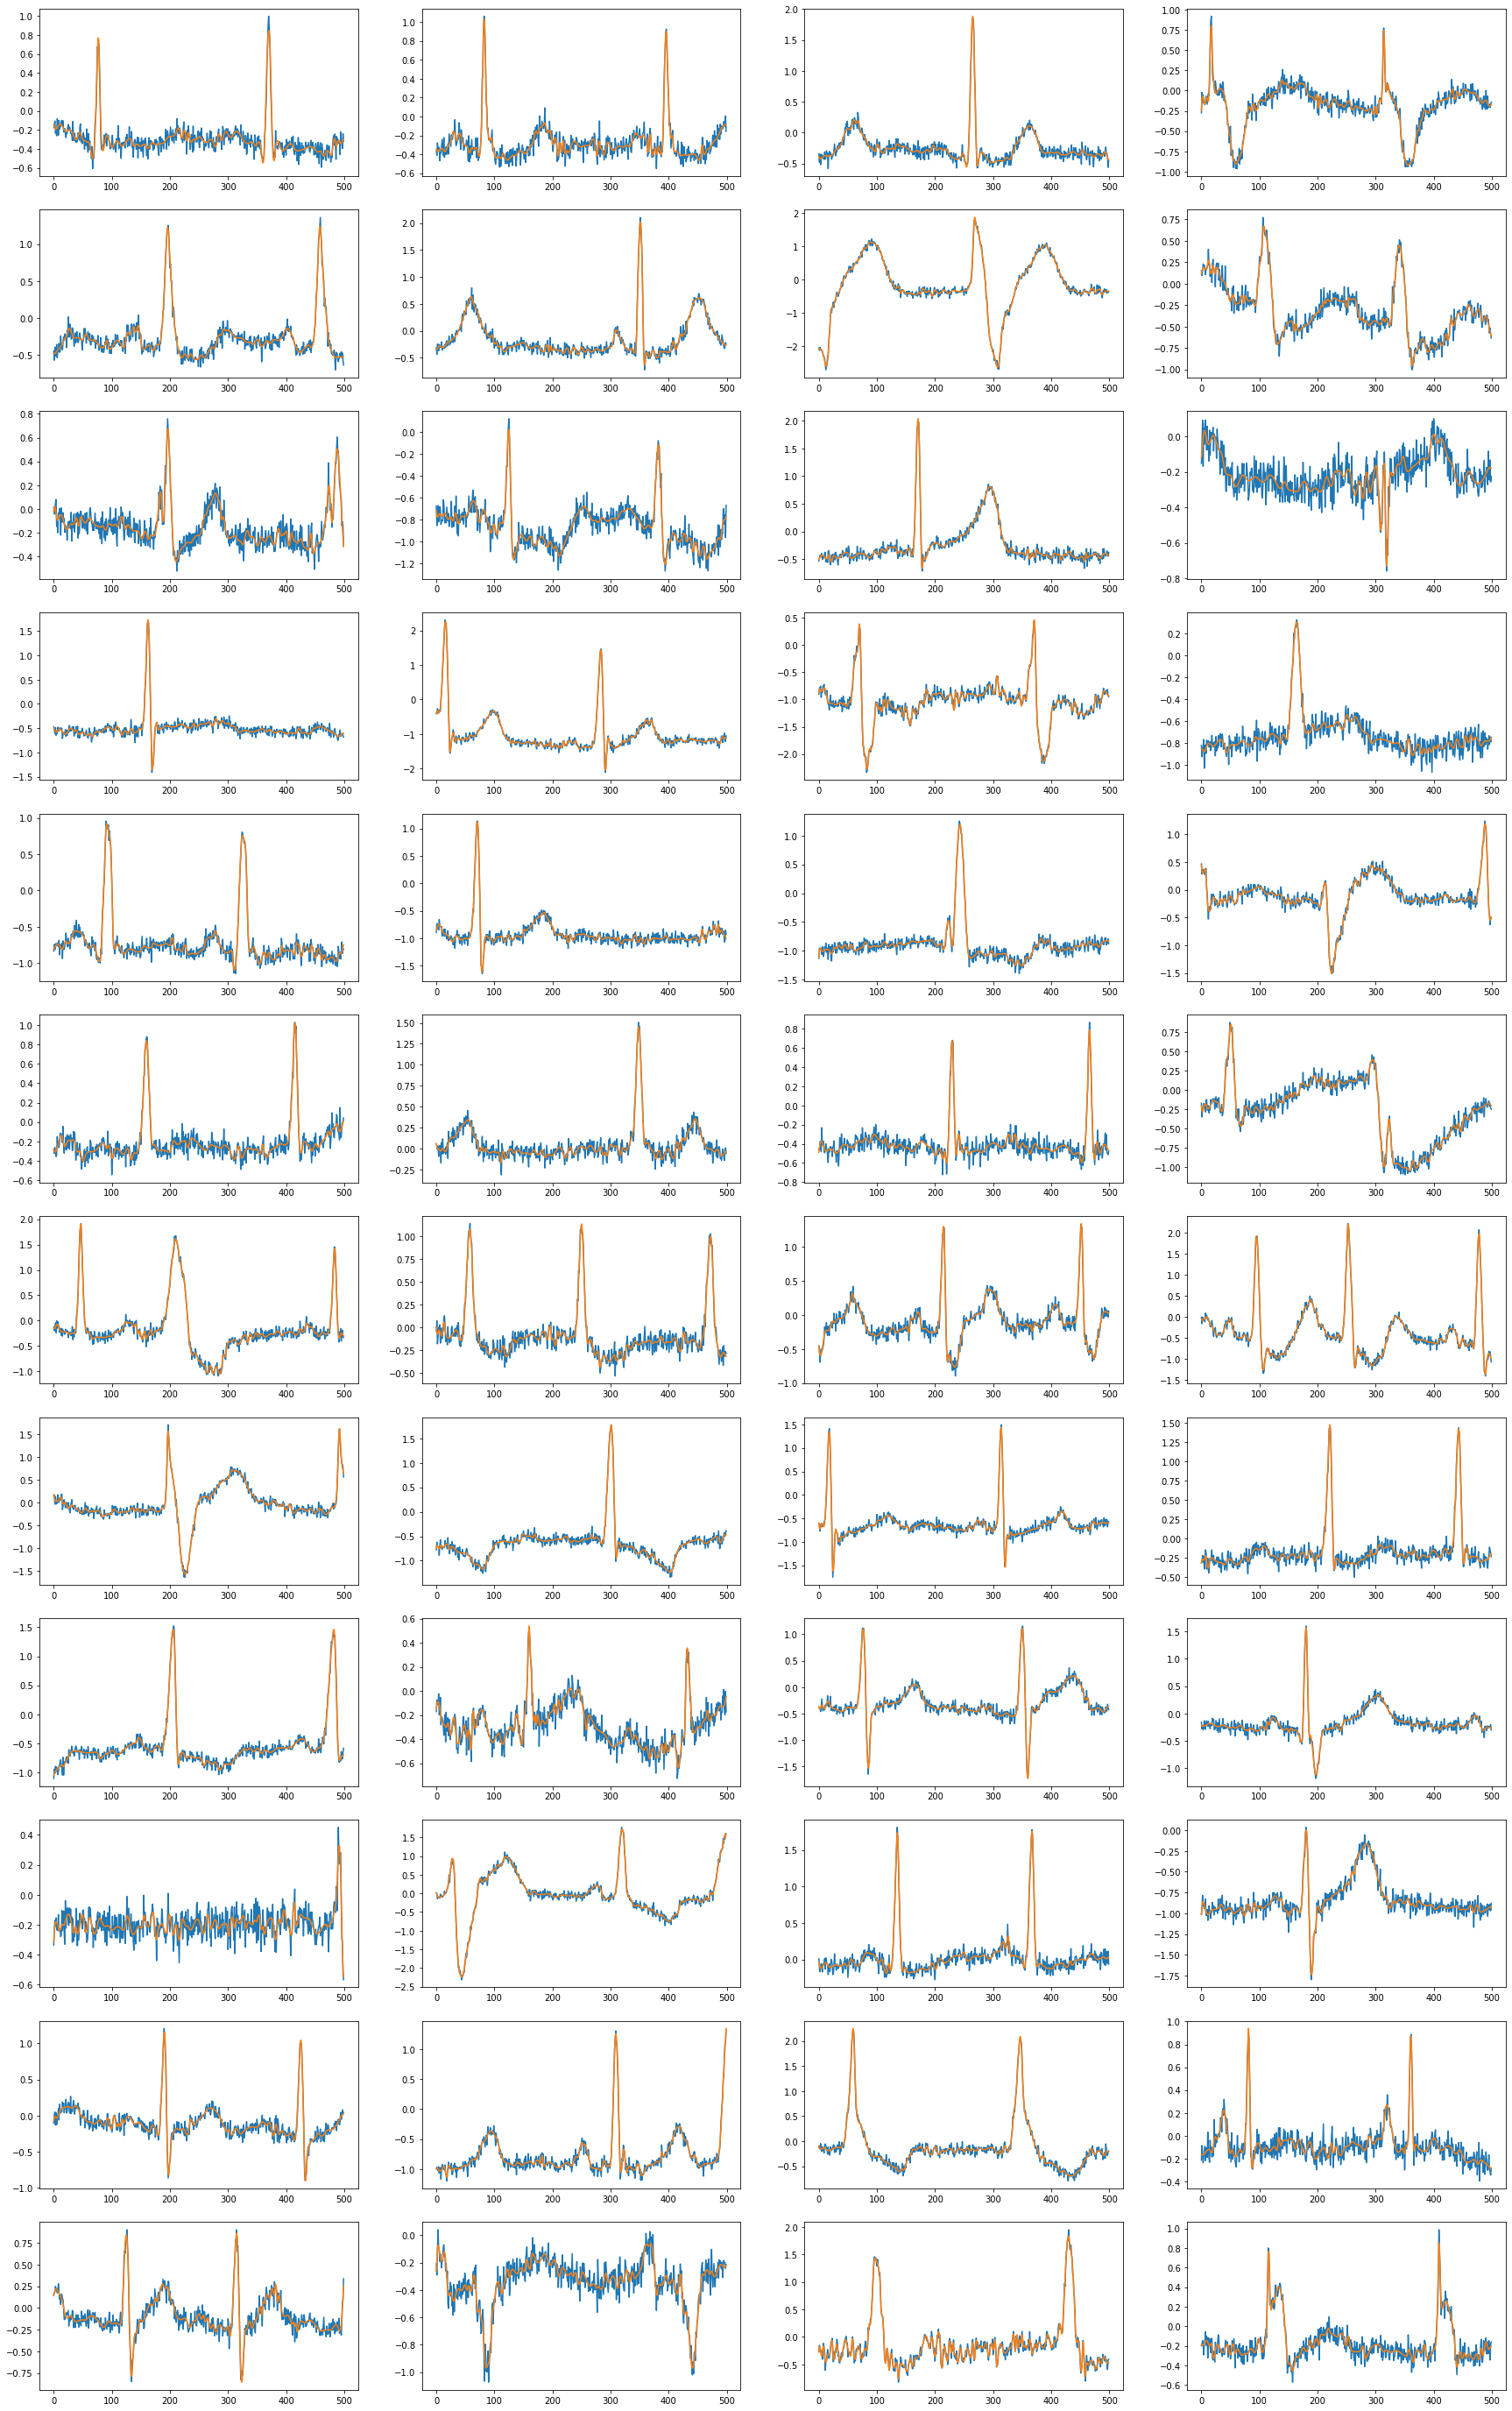

In [ ]:
plt.suptitle('Zaszumione sygnały EKG i po odszumieniu metodą spline approximation')
fig = plt.figure(figsize=(30, 50))
for i in range(1, nsignals+1):
  ax = fig.add_subplot(nsignals/4,4,i)
  ax.plot(noisyData[i-1][:500])
  ax.plot(denoised_signal_spline[i-1][:500])
plt.show()

Algorytm 2 - Autoregressive Model - Jan Filip & Konrad Wyszyński



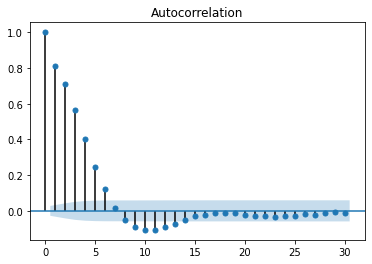

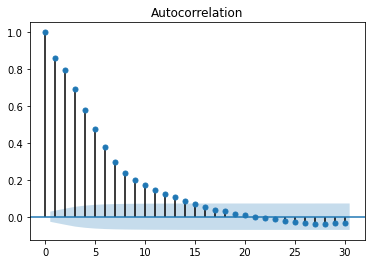

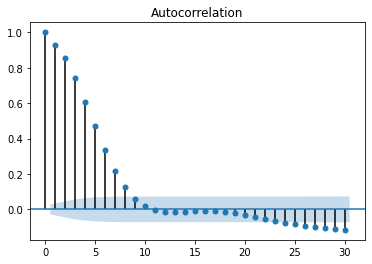

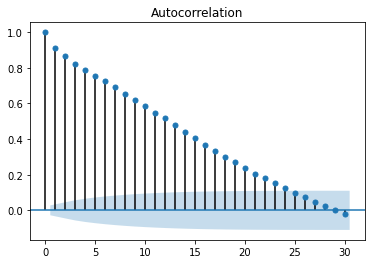

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
for i in range(4):
  signal = noisyData[i]
  y = signal[:]
  plot_acf(y, lags=30)
  plt.show()

In [ ]:
lags = []
for i in noisyData:
  for j in range(i.shape[0]):
    if pd.Series(i).autocorr(lag=j) < 0.2:
      lags.append(j)
      break

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
 

<Figure size 432x288 with 0 Axes>

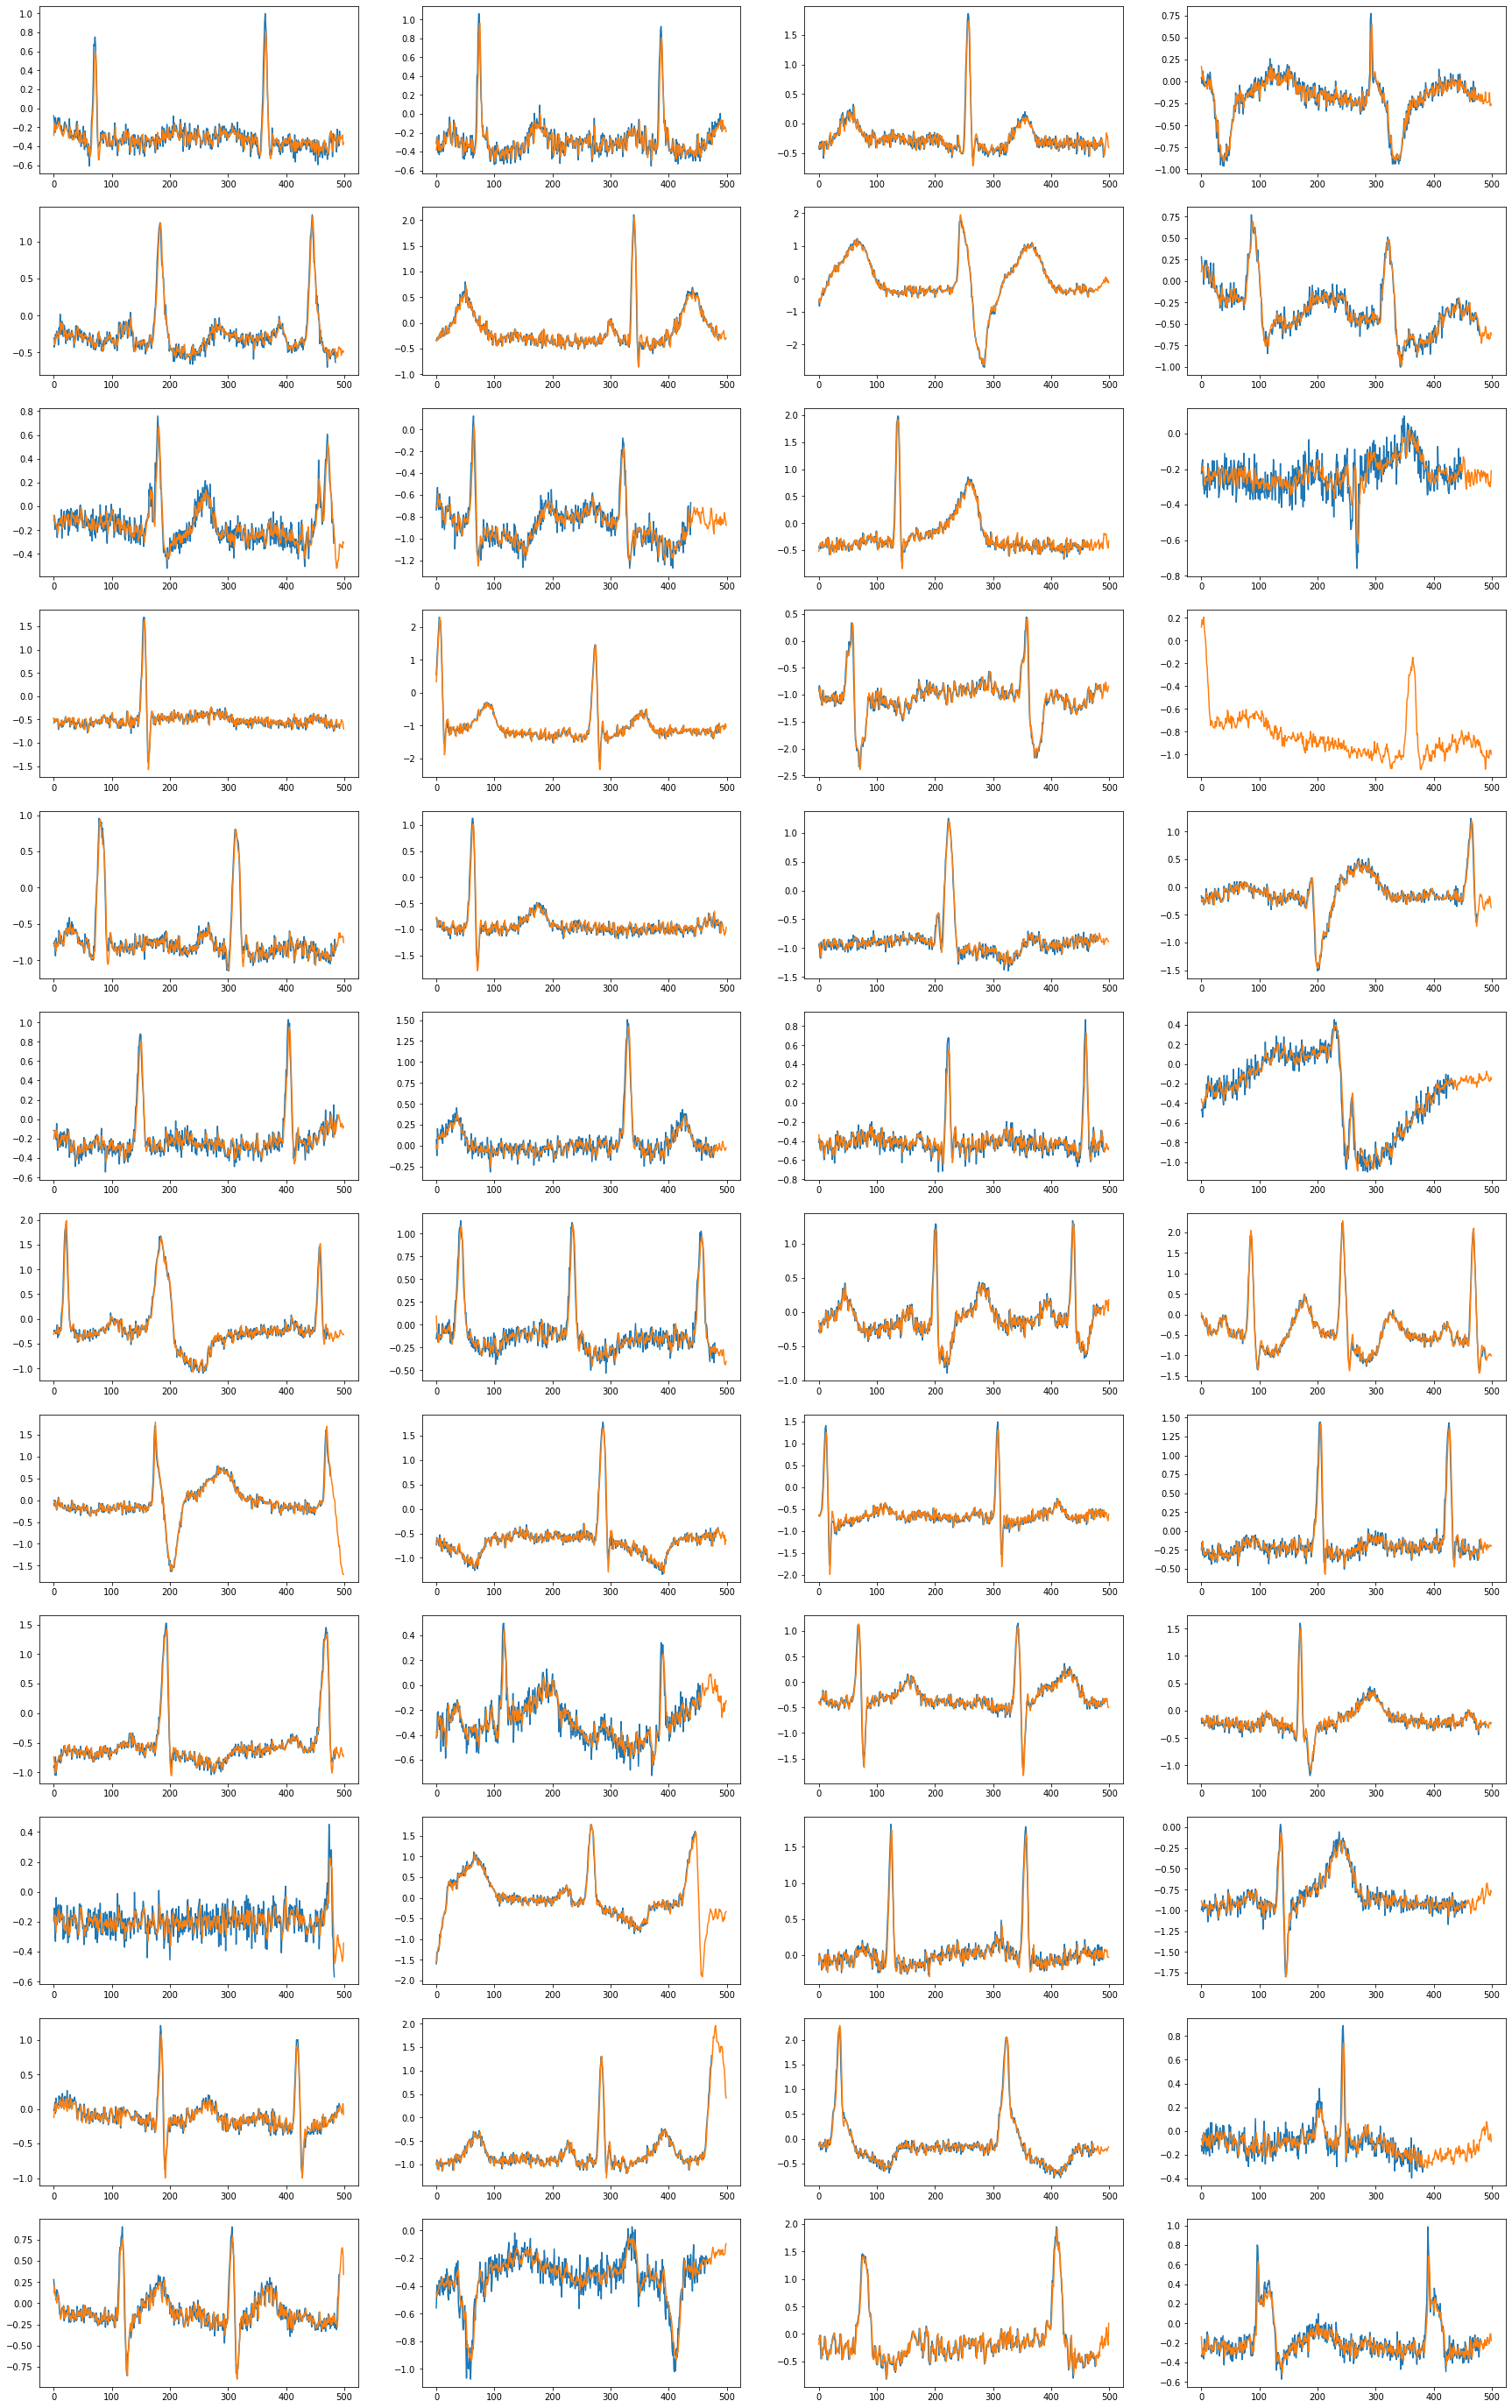

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
denoised_signal_ar = []
for y, i in zip(noisyData,lags):
  model = AutoReg(y, lags=i)
  result = model.fit()
  fitted_values = model.predict(result.params, start=0, end =5000)
  denoised_signal_ar.append(fitted_values)
  #print("Parametry modelu AR:",result.params)
  #print("Wartości przewidziane Xt:", fitted_values)

plt.suptitle('Zaszumione sygnały EKG i po odszumieniu metodą modelu AR')
fig = plt.figure(figsize=(30, 50))
for i in range(1, nsignals+1):
  ax = fig.add_subplot(nsignals/4,4,i)
  ax.plot(noisyData[i-1][lags[i-1]:500])
  ax.plot(denoised_signal_ar[i-1][:500])
plt.show()

Algorytm 3 - Wavelet Transform



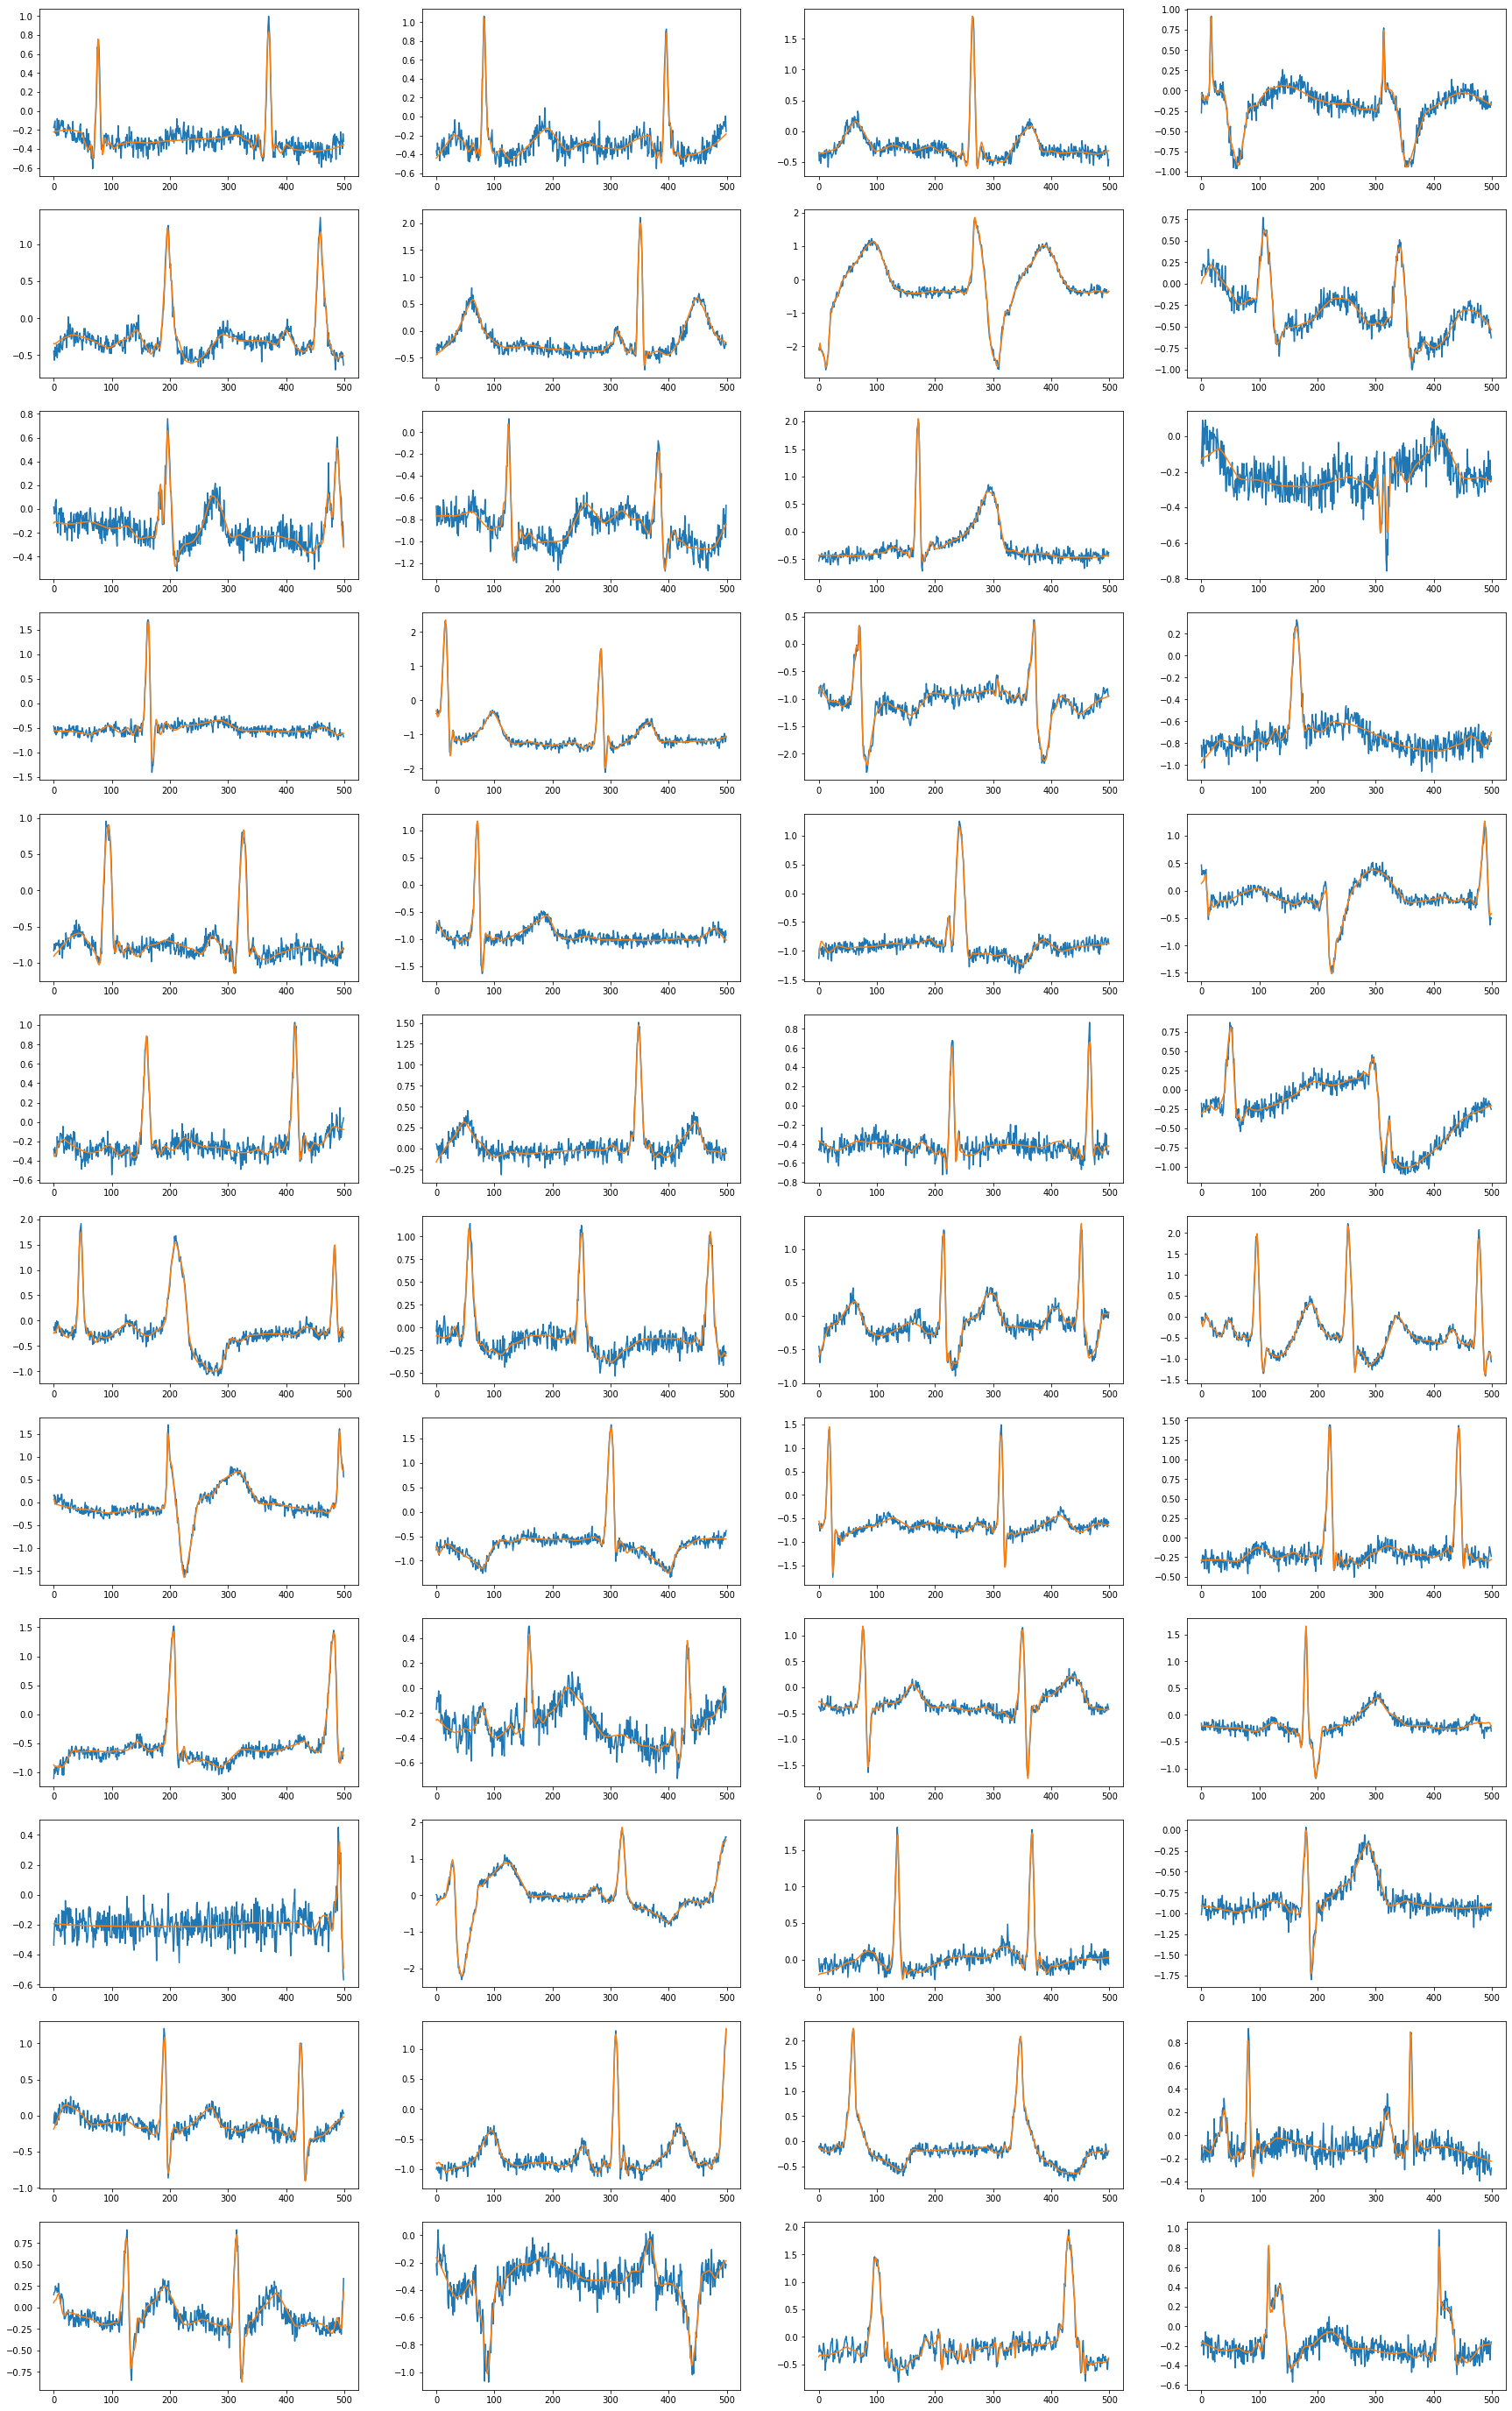

In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet, level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    var = statistics.variance(signal) # wariancja sygnalu
    uthresh = var * np.sqrt(2 * np.log(len(x))) # ze wzoru - literatura
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

wav='bior4.4'
filtered = []
for i in noisyData:
  filtered.append(wavelet_denoising(i, wavelet=wav, level=1))

#fig, axs = plt.subplots(4,len(filtered))

  #plt.figure(figsize=(10, 6))
  #plt.plot(i, label='Zaszumiony')
  #plt.plot(filtered, label='Odfiltrowany')
  #plt.legend()
  #plt.title(f"DWT Odszumiane falką {wav}", size=15)
  #plt.show()
fig = plt.figure(figsize=(30, 50))
for i in range(1, nsignals+1):
  ax = fig.add_subplot(nsignals/4,4,i)
  ax.plot(noisyData[i-1][:500])
  ax.plot(filtered[i-1][:500])
plt.show()




Testowanie

Parametry:

• korelacja krzyżowa

• MSE

• MAE

• SNR

In [ ]:
from scipy.stats.stats import pearsonr   
from sklearn.metrics import mean_squared_error,mean_absolute_error
def crosscorr(datax, datay):
    return pearsonr(datay,datax)

def MSE(filtered, signal):
    mse = mean_squared_error(filtered, signal)
    return mse

def MAE(filtered, signal):
    mae = mean_absolute_error(filtered, signal)
    return mae  

def SNR(filtered, noisy):
    VppFiltered = max(filtered) - min(filtered)
    VppNoisy = max(noisy) - min(noisy)
    snr = VppFiltered / VppNoisy
    snrDB = 20 * log10(snr)
    return snrDB

In [ ]:
#SPLINE FUNCTION
denoised_signal_spline = np.array(denoised_signal_spline)
mse = MSE(denoised_signal_spline, np.array(data))
mae = MAE(denoised_signal_spline, np.array(data))
snr = []
corr = []
for i,j in zip(denoised_signal_spline, data):
  snr.append(SNR(i,j))
  corr.append(crosscorr(i, j)[0])
snr = sum(snr)/len(snr)
corr = sum(corr)/len(corr)
print("MSE = ", mse)
print("MAE = ", mae)
print("SNR = ", snr)
print("CORR = ", corr)
#AUTO REGRESSIVE MODEL
denoised_signal_ar = np.array(denoised_signal_ar)
mse = []
mae = []
snr = []
corr = []
for i,j in zip(denoised_signal_ar, data):
  snr.append(SNR(i,j))
  mse.append(MSE(i,j[:i.shape[0]]))
  mae.append(MAE(i,j[:i.shape[0]]))
  corr.append(crosscorr(i, j[:i.shape[0]])[0])
corr = sum(corr)/len(corr)
snr = sum(snr)/len(snr)
mse = sum(mse)/len(mse)
mae = sum(mae)/len(mae)
print("MSE = ", mse)
print("MAE = ", mae)
print("SNR = ", snr)
print("CORR = ", corr)
#WAVELET TRANSFORM
#SNR(filtered,signal)
waveletCorr = []
for i,j in zip(filtered, data):
  waveletCorr.append(crosscorr(i,j))
waveletCorr=np.array(waveletCorr)
waveletCorr=np.mean(waveletCorr[:,0])
print(f"Wartosc corr dla falki {wav} wynosi {waveletCorr}  ")    

MSE =  0.003999772261586551
MAE =  0.05085468272590358
SNR =  -0.508446986842524
CORR =  0.9706767987289852
MSE =  0.21712542213870803
MAE =  0.2358885785188137
SNR =  -0.542554295476684
CORR =  0.18990756782344043
Wartosc corr dla falki bior4.4 wynosi 0.9541007639996514  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
